# 贝叶斯优化模型超参范例
    BayesianOptimization-master
    https://github.com/fmfn/BayesianOptimization

## 实验目的    
* 掌握 贝叶斯优化方法 自动搜索模型超参


## 实验数据说明
    随机构造的二维数据(x,y)，分10类
    x+y >0,<=0.2    =>0
    x+y >0.2,<=0.4  =>1
    x+y >0.4,<=0.6  =>2
    x+y >0.6,<=0.8  =>3
    x+y >0.8,<=1.0  =>4
    x+y >1.0,<=1.2  =>5
    x+y >1.2,<=1.4  =>6
    x+y >1.4,<=1.6  =>7
    x+y >1.6,<=1.8  =>8
    x+y >1.8,<=2.0  =>9

In [1]:
%matplotlib inline

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

Using TensorFlow backend.


## 参数设置

In [2]:
import os

data_path='%s/work/data/gtest/classify'%os.getenv('HOME')#数据目录

epochs=3
num_class=10
batch_size=32

## 数据生成器

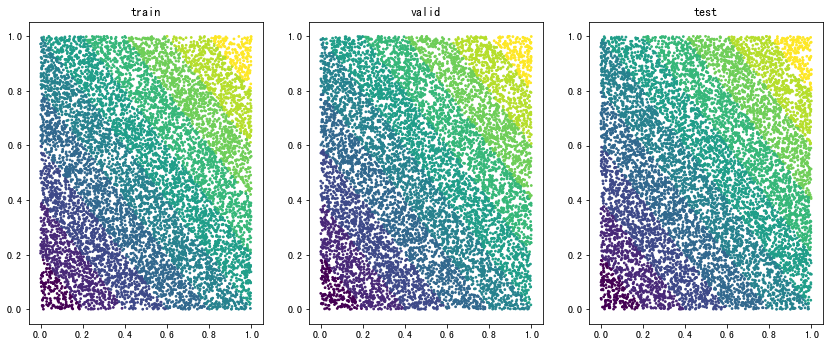

In [3]:
#构造数据
import numpy as np
from keras.utils.np_utils import to_categorical

num_train=10000  #训练样本数
num_valid=10000  #校验样本数
num_test=10000   #测试样本数
num_class=10     #样本分类数

#数据分类
def x2y(x,n_class):
    x_sum=np.sum(x,axis=1)
    y=np.zeros((len(x_sum),),dtype=np.int32)    
    x_step=np.linspace(0,2,n_class+1)
    x_step[0]=-1
    x_step[-1]=3
    for i in range(n_class):
        index=np.where((x_sum>x_step[i])&(x_sum<=x_step[i+1]))[0]
        y[index]=i
    return y

#训练数据
x_train=np.random.rand(num_train,2)
y_train=x2y(x_train,num_class)
y_train_labels = to_categorical(y_train)   #one-hot编码
#校验数据
x_valid=np.random.rand(num_valid,2)
y_valid=x2y(x_valid,num_class)
y_valid_labels=to_categorical(y_valid)     #one-hot编码
#测试数据
x_test =np.random.rand(num_test ,2)
y_test =x2y(x_test,num_class)
y_test_labels=to_categorical(y_test)       #one-hot编码

#======绘制散点图======
import matplotlib.pyplot as plt
plt.figure(figsize=(1024/72.,400/72.))
plt.subplot(1,3,1)
plt.scatter(x_train[:,0], x_train[:,1], s=3, c=y_train)
plt.title('train')
plt.subplot(1,3,2)
plt.scatter(x_valid[:,0], x_valid[:,1], s=3, c=y_valid)
plt.title('valid')
plt.subplot(1,3,3)
plt.scatter(x_test[:,0], x_test[:,1], s=3, c=y_test)
plt.title('test')
plt.show()

## 模型优化说明
    模型类型：序贯模型
    优化参数：
        网络层数  (1,5)
        每个层有两个优化参数：
            神经元数目 [2,4,8,16,...1024]
            激活函数   ['relu','tanh']
            
    L1k,L1s,L1a,L2k,L2s,L2a,L3k,L3s,L3a,L4k,L4s,L4a,L5k,L5s,L5a,L6k,L6s,L6a
    

In [4]:
from keras import models,layers,optimizers



In [5]:
#网络创建函数
def build_model(layers_num,*args):
    layers_num=int(layers_num)
    filter_num={i:2**i for i in range(1,11)}
    act_fun={1:'relu',2:'linear',3:'tanh'}

    model = models.Sequential()
    for i,arg in enumerate(args):
        if i==0:
            model.add(layers.Dense(arg[0],input_shape=(2,), activation=arg[1],name='dense_0'))
        elif i<layers_num:
            model.add(layers.Dense(arg[0], activation=arg[1],name='dense_%d'%i))
    model.add(layers.Dense(10, activation='softmax',name='dense_o'))

    #打印模型
    #model.summary()

    #模型编译
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
    return model

#网络训练
def train_model(model,x,y):
    model.fit(x,y,epochs=3,validation_split=0.2,verbose=0)
    
#网络预测
def pred_model(model,x,y_true):
    y_pred=model.predict(x,verbose=0)    
    y_pred=np.argmax(y_pred,axis=1)
    #=======正确率统计======
    y_pred=np.reshape(y_pred,(-1))
    acc=1.0-np.count_nonzero(y_pred-y_test)*1.0/len(y_pred)
    return acc

## 模型优化

In [6]:
#模型优化函数
def opt_model(layers_num,L1k,L1a,L2k,L2a,L3k,L3a,L4k,L4a,L5k,L5a):
    layers_num=int(layers_num)
    filter_num={i:2**i for i in range(1,11)}
    act_fun={1:'relu',2:'linear',3:'tanh'}

    L1k=filter_num[int(L1k)]
    L1a=act_fun[int(L1a)]
    
    L2k=filter_num[int(L2k)]
    L2a=act_fun[int(L2a)]
    
    L3k=filter_num[int(L3k)]
    L3a=act_fun[int(L3a)]
    
    L4k=filter_num[int(L4k)]
    L4a=act_fun[int(L4a)]
    
    L5k=filter_num[int(L5k)]
    L5a=act_fun[int(L5a)]
    
    model=build_model(layers_num,(L1k,L1a),(L2k,L2a),(L3k,L3a),(L4k,L4a),(L5k,L5a))
    train_model(model,x_train,y_train_labels)
    acc=pred_model(model,x_test,y_test)
    return acc

In [7]:
layers_num=1
L1k=1
L1a=1
L2k=1
L2a=1
L3k=1
L3a=1
L4k=1
L4a=1
L5k=1
L5a=1
#acc=opt_model(layers_num,L1k,L1a,L2k,L2a,L3k,L3a,L4k,L4a,L5k,L5a)
#print(acc)

## 模型优化

In [8]:
from bayes_opt import BayesianOptimization

#模型优化-调参
def do_opt_model():
    #定义优化函数
    black_box_function=opt_model
    #定义优化参数
    pbounds={
            'layers_num':(1,5),
            'L1k':(1,10),
            'L1a':(1,2),
            'L2k':(1,10),
            'L2a':(1,2),
            'L3k':(1,10),
            'L3a':(1,2),
            'L4k':(1,10),
            'L4a':(1,2),
            'L5k':(1,10),
            'L5a':(1,2)
            }
    #构建优化器
    optimizer = BayesianOptimization(
        f=black_box_function,
        pbounds=pbounds,
        verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=1,
    )
    #优化
    optimizer.maximize(
        init_points=2,
        n_iter=10,
    )
    #最优结果
    print(optimizer.max)

In [9]:
do_opt_model()

|   iter    |  target   |    L1a    |    L1k    |    L2a    |    L2k    |    L3a    |    L3k    |    L4a    |    L4k    |    L5a    |    L5k    | layers... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.1832   |  1.417    |  7.483    |  1.0      |  3.721    |  1.147    |  1.831    |  1.186    |  4.11     |  1.397    |  5.849    |  2.677    |
|  2        |  0.1875   |  1.685    |  2.84     |  1.878    |  1.246    |  1.67     |  4.756    |  1.559    |  2.263    |  1.198    |  8.207    |  4.873    |
|  3        |  0.1826   |  1.96     |  1.137    |  1.615    |  9.908    |  1.252    |  9.685    |  1.0      |  9.942    |  1.959    |  1.408    |  1.817    |
|  4        |  0.8154   |  1.439    |  9.718    |  1.849    |  9.893    |  1.976    |  9.823    |  1.403    |  1.075    |  1.822    |  9.608    |  3.668    |
|  5        |  0.8102   |  1.0      |  10.0     |  2